<a href="https://colab.research.google.com/github/zackklimek/CacheLabCode/blob/master/klimek_hw1_knn_naivebayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1 - KNN and Naive Bayes Classification
### Zack Klimek | CIS 378-01 | 2/7/2022

Note: I was not able to complete the questions related to baseline accuracy. I recall covering this in class, but will plan on meeting in office hours to review how to calcuate it for a given problem.

## Problem 1 - EMNIST Letters Classification
*This problem is based on the MNIST Exercises from Chapter 2 of Applied Machine Learning by David Forsyth (2019).*

[EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset) [1] is a large image dataset for character and letter recognition. It was designed to be an extended version created in the same format as the original (and very popular) MNIST dataset which contained only digits.

EMNIST contains a variety of sub datasets for general character, digit only, and alphabetical character only recognition.  In this problem, we are going to look at EMNIST Letters:  a balanced dataset with only alphabetical letters (26 classes, upper and lowercase are both labeled to the same class).

<hr>

1. Load in the dataset (both training and test sets) so that each sample (e.g. image) is one row.  Each row should be of lenght 784 (each image is $28 \times 28$, so if you view each pixel as a feature you would have $28 \times 28$ features for each image.  You can confirm that you've done it correctly by looking at the 20th image in the training set (which should very clearly be a `B`).  You can plot it with the following where you would need to uncomment one of the two `order = ...` lines (which one depends on which of the two options below that you use to access the data.)

[emnist python package](https://pypi.org/project/emnist/) to access the dataset
<hr/>

In [ ]:
!pip install pyflann-py3
!pip install emnist

In [2]:
from emnist import list_datasets
from emnist import extract_training_samples
letter_images, labels = extract_training_samples('letters')

<hr/>

In [3]:
import numpy as np

# For each image, extend a temporary array with each row in the image's 2d ndarray
image_lists = []

for image in letter_images:
  temp_features = []
  for row in image:
    temp_features.extend(row)
  image_lists.append(temp_features)

# Convert list of lists to 2d numpy array - use image_arrays and labels for models
image_arrays = np.array(image_lists)

Plotting image with [matplotlib.pyplot](https://matplotlib.org/stable/tutorials/introductory/images.html). Confirms the letter 'B' at index 20 for the original 3d ndarray and the transformed 2d array.

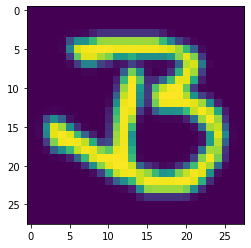

In [4]:
import matplotlib.pyplot as plt
order = 'c'
# order = 'f'

plot2 = plt.imshow(image_arrays[20].reshape((28,28),order=order))

sklearn [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), [Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html), [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [149]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_arrays, labels, test_size=0.25)

<hr>
<p> 
2. Using sklearn, build and evaluate a k-nearest neighbors classifier. Use cross-validation to evaluate (you might want to look at sklearn's docs on how to use cross-validation with their models, what validation accuracy do you get? Choose a relatively small value for 
 (somewhere between 3 and 5).
 </p> 

Fit KNN classifier using the training data and training data labels.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

Split training data using cross-validation while evaluating models - [sklearn: predict()](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict)

[3.1 Cross-validation: evaluating estimator performance (sklearn)](https://scikit-learn.org/stable/modules/cross_validation)

In [ ]:
from sklearn.model_selection import cross_val_score
knn_scores = cross_val_score(knn, X_train, y_train, cv=4)

print('KNN (sklearn) Average Scores:', sum(knn_scores)/len(knn_scores))

KNN (sklearn) Average Scores: 0.8483760683760684


<hr>
<h4>
3. Build and evaluate an approximate nearest neighbors classifier using FLANN. FLANN is a package for performing nearest neighbor search in high-dimensional spaces. It's actually in C++, but there's python bindings available in pyflann. Admittedly, the pyflann documentation isn't great, so you'll probably need to do some googling to figure out the calls. You want to use build_index and nn_index rather than just nn which is what they show in most examples (nn isn't fantastic because it rebuilds the index every time). You can either implement cross-validation on your own or you can just <u>separate the training set into a training set and validation set</u> (since there's no easy way to do cross-validation automatically with flann). Note -- when you use pyflann to predict, it doesn't
</h4>

[FLANN repository](https://github.com/flann-lib/flann) (Fast Library for Approximate Nearest Neighbors)

[pyflann docs](https://wbia-tpl-pyflann.readthedocs.io/en/latest/pyflann.html)

In [150]:
# Split complete dataset into training and test sets (repeated from above)
X_train, X_test, y_train, y_test = train_test_split(image_arrays, labels, test_size=0.25)

In [151]:
# Split training set into training set and validation set (4 folds)
X_train2, X_validation, y_train2, y_validation = train_test_split(X_train, y_train, test_size=0.25)

In [179]:
from pyflann import FLANN
flann = FLANN()

In [184]:
# fits ANN model
b_i_return = flann.build_index(X_train2)

# returns results, array of num_neighbors closest neighbors
nn_return = flann.nn_index(X_validation, num_neighbors=9) 

neighbors = nn_return[0]  # neighbors of each element in test/valid set

In [185]:
validation_correct = 0
for v in range(len(X_validation)):
  # set of X_validation[v]'s nearest neighbors
  nn_set = {}
  # at element v in the validation set, iterate through each neighbor
  # index - index of v's neighbor in X_train2
  for index in neighbors[v]:
    prediction = y_train2[index]
    if prediction in nn_set:
      nn_set[prediction] = nn_set[prediction] + 1
    else:
      nn_set[prediction] = 1
  max_val = 0
  max_label = 0
  for key in nn_set:
    if nn_set[key] > max_val:
      max_val = nn_set[key]
      max_label = key
  if max_label == y_validation[v]:
    validation_correct = validation_correct + 1

print('FLANN Validation Accuracy = ', validation_correct/len(X_validation))

FLANN Validation Accuracy =  0.7874786324786325


<h4>How does the validation accuracy compare to sklearn's nearest neighbors? How about the runtime?<h4>

<p>sklearn's KNN model produced an average validation accuracy of <u>84.75%</u> using 4-folds cross validation. Splitting the training set into another training set and validation set produced an average validation accuracy of <u>79.67%</u> using FLANN's ANN model. sklearn's cross-validation runtime averaged around 9 minutes (~1.8 minutes per fold), while FLANN enabled validation accuracy to be predicted in under a second after the validation set's nearest neighbors were generated.</p>

<h4>Try different number of neighbors between 2 and 10. Based on the validation accuracy, what is the best value for number of neighbors?<h4>
<p>For this dataset, validation accuracy has an inverse relationship with the number of neighbors considered. <u>3 neighbors</u> consistently classified the validation sets the best. </p>

<p>
<table>
<tr>
  <td># of Neighbors</td>
  <td>FLANN Avg. Validation Accuracy</td>
  <td>Avg. V.A. Trial #2</td>
</tr>
<tr> 
  <td>2</td>
  <td>80.65%</td>
  <td>80.46%</td>
</tr>
<tr> 
  <td><b>3</b></td>
  <td><b>80.75%</b></td>
  <td><b>80.64%</b></td>
</tr>
<tr> 
  <td>5</td>
  <td>79.93%</td>
  <td>80.39%</td>
</tr>
<tr> 
  <td>7</td>
  <td>78.91%</td>
  <td>79.38%</td>
</tr>
<tr> 
  <td>9</td>
  <td>78.42%</td>
  <td>78.75%</td>
</tr>
</table>
</p>

<hr/>
<h4>
4. Using sklearn, build and evaluate a Gaussian Naive Bayes classifier. How well does it do? For comparison, try building a Gaussian Naive Bayes Classifier on the EMNIST digits dataset -- does Gaussian Naive Bayes do better on the digits than it does on the letters (pay attention to the <em>baseline accuracy</em> for each).

[sklearn GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
</h4>

<h5>EMNIST Letters</h5>
<p><u>GNB Average Scores: 34.50%</u></p>

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_arrays, labels, test_size=0.25)

(93600, 784) (93600,)


In [7]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [9]:
from sklearn.model_selection import cross_val_score
gnb.fit(X_train, y_train)
gnb_scores = cross_val_score(gnb, X_train, y_train, cv=5)

In [10]:
print('GNB (sklearn) Average Scores:', sum(gnb_scores)/len(gnb_scores))

GNB (sklearn) Average Scores: 0.3449786324786325


<h5>EMNIST Numbers</h5>
<p><u>GNB Average Scores: <b>65.37%</b></u></p>

In [3]:
number_images, number_labels = extract_training_samples("digits")
number_images.shape

(240000, 28, 28)

In [4]:
import numpy as np

number_lists = []

for image in number_images:
  temp_features = []
  for row in image:
    temp_features.extend(row)
  number_lists.append(temp_features)

number_arrays = np.array(number_lists)
number_arrays.shape

(240000, 784)

In [5]:
from sklearn.model_selection import train_test_split

X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(number_arrays, number_labels, test_size=0.25)

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
gnb_num = GaussianNB()

gnb_num.fit(X_num_train, y_num_train)
gnb_num_scores = cross_val_score(gnb_num, X_num_train, y_num_train, cv=5)

print('GNB (sklearn) Average Scores (digits dataset):', sum(gnb_num_scores)/len(gnb_num_scores))

GNB (sklearn) Average Scores (digits dataset): 0.6537111111111111


<h4>5. Can you improve one or more of these models (this will take experimentation). Things to try would include preprocessing of the data (thresholding, re-centering/stretching with different bounding boxes, data augmentation, etc.). It's okay if you can't improve, just try a couple things).</h4>

<h5>Thresholding</h5>

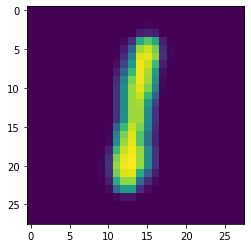

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(image_arrays, labels, test_size=0.25)

plot2 = plt.imshow(X_test[0].reshape((28,28),order='C'))

In [67]:
# Thresholding - invert colors
for x in range(0, 10):
  for y in range(0, len(X_train[x])):
    if X_test[x][y] > 0:
      X_test[x][y] = 0
    else:
      X_test[x][y] = 250

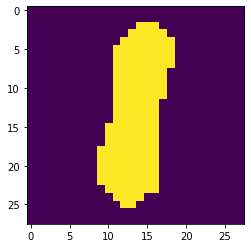

In [68]:
plot2 = plt.imshow(X_test[0].reshape((28,28),order='C'))

In [61]:
knn_thresh = KNeighborsClassifier(n_neighbors=5)
knn_thresh.fit(X_train, y_train)
knn_thresh_scores = cross_val_score(knn_thresh, X_test, y_test, cv=5)

In [69]:
print("KNN with Thresholding: Average Validation Score = ", sum(knn_thresh_scores)/len(knn_thresh_scores))

KNN with Thresholding: Average Validation Score =  0.8084615384615385


<h4>6. Based on the validation accuracies you achieved in the previous parts, what is the best model? Evaluate that model on the test set. Create a confusion matrix to evaluate the results -- which letters is it most unable to determine between? Since there are so many classes -- you should probably visualize the conusion matrix with a plot (see sklearn's ConfusionMatrixDisplay</h4>

<h4>EMNIST Letter Classification Model Performance</h4>
<table>
  <tr>
    <td>Model</td>
    <td>Source</td>
    <td>Validation Accuracy</td>
    <td>Folds</td>
  </tr>
  <tr>
    <td><b>KNN</b></td>
    <td><b>sklearn<b></td>
    <td><b>84.75%<b></td>
    <td><b>4 (Cross-val)<b></td>
  </tr>
    <tr>
    <td>ANN</td>
    <td>FLANN</td>
    <td>79.67%</td>
    <td>1 (No cross-val)</td>
      <tr>
    <td>Gaussian NB</td>
    <td>sklearn</td>
    <td>35.42%</td>
    <td>4 (Cross-val)</td>
  </tr>
  <tr>
    <td>KNN with Thresholding</b></td>
    <td>sklearn</td>
    <td>80.85%</td>
    <td>5 (Cross-val)</td>
  </tr>
  </tr>
</table>

In [70]:
# Repeats the original train_test_split call from the entire dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_arrays, labels, test_size=0.25)

In [ ]:
# Fits KNN model with training set, stores predictions
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

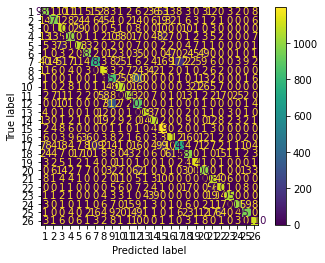

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Creates confusion matrix from predictions
cm = confusion_matrix(y_test, predictions, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

<p>Based on the confusion matrix, G (label == 7), I (label == 9)and P (label == 16) were least frequently predicted as their correct label for the test set. </p>

<hr/>
<hr/>

## Problem 2 - SMS Spam vs Ham Classification

A common use of Naive Bayes is for text classification. When using Naive Bayes for text classification a common choice is to use a "bag of words" representation of a document. The "bag of words" representation assumes position doesn't matter and instead focuses on how common each word is in a document.

The dataset for this problem is https://archive.ics.uci.edu/ml/datasets/sms+spam+collection. Don't forget to separate the dataset into train/test splits (this dataset isn't preseparated) and use cross-validation (either k-fold cross validation or by separating the dataset into train/test/validate subsets). You might want to consider "stratified" sampling when doing your dataset splitting due to the imbalance in the dataset.

Dataset [source](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/smsspamcollection/SMSSpamCollection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
import pandas as pd
# 5571 elements
df=pd.read_table(path)

Renames df column names, translates spam/ham to 1/0.

In [115]:
# Stores column name, "Go until jurong point, crazy...", to variable
text_col_name = df.columns[1]
# Renames df columns
df = df.rename(columns={"ham":"label", text_col_name:'texts'})
text_labels = df['label']
# Reassigns label values to integers
for i in range(0, len(df['label'])):
  df['label'][i] = "1" if text_labels[i] == 'spam' else "0"

df

,label,texts
0,0,Ok lar... Joking wif u oni...
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives aro..."
4,1,FreeMsg Hey there darling it's been 3 week's n...
...,...,...
5566,1,This is the 2nd time we have tried 2 contact u...
5567,0,Will ü b going to esplanade fr home?
5568,0,"Pity, * was in mood for that. So...any other s..."
5569,0,The guy did some bitching but I acted like i'd...


<h4>1. Using sklearn, build and evaluate a Multinomial Naive Bayes classifier to classify the text messages as "spam" or "ham" (e.g. not spam). You'll need to get the word counts first (you may want to consider using sklearn's <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">CountVectorizer</a>, but you are also free to process the data manually).

[sklearn MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)</h4>


In [97]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(df['texts'], df['label'], test_size=0.25)

[fit_transform()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform)

In [104]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

c_v = CountVectorizer()
X = c_v.fit_transform(X_text_train)

# Array: each feature/attr. is a word/token in the vocabulary
X_arr_train = X.toarray()

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [66]:
# Each element in the training set is represented by a vector with the
# frequency of each word in the entire vocabulary
X_text_train.shape

(4178,)

<h4>2. Experiment with different preprocessing steps ( -- somethings you may want to consider are <b>removing stop words</b>, removing numbers, dropping infrequent words, etc.)</h4>

[nltk (Natural Language Tool Kit) stopwords](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/) - previously used in CIS 365 & personal work

In [128]:
import pandas as pd
# 5571 elements
df_nostop=pd.read_table(path)

text_col_name = df_nostop.columns[1]
df_nostop = df_nostop.rename(columns={"ham":"label", text_col_name:'texts'})
text_labels = df_nostop['label']
for i in range(0, len(df_nostop['label'])):
  df_nostop['label'][i] = "1" if text_labels[i] == 'spam' else "0"

In [129]:
import nltk
nltk.download('stopwords')
swords = set(stopwords.words('english'))

# Removing stopwords from each string before model
abbreviated_texts = []
for i in range (0,len(df_nostop['texts'])):
  stopwords_removed = ""
  # print(df_nostop['texts'][i])
  for x in df_nostop['texts'][i].split(" "):
    if x.lower() not in swords:
      stopwords_removed += x + " "
  abbreviated_texts.append(stopwords_removed)
  # print(stopwords_removed)
  # print()
  
df_nostop['texts'] = abbreviated_texts

# df updated with stopwords removed
df_nostop

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,texts
0,0,Ok lar... Joking wif u oni...
1,1,Free entry 2 wkly comp win FA Cup final tkts 2...
2,0,U dun say early hor... U c already say...
3,0,"Nah think goes usf, lives around though"
4,1,FreeMsg Hey darling 3 week's word back! I'd li...
...,...,...
5566,1,2nd time tried 2 contact u. U £750 Pound prize...
5567,0,ü b going esplanade fr home?
5568,0,"Pity, * mood that. So...any suggestions?"
5569,0,guy bitching acted like i'd interested buying ...


<h4>3. Evaluate your best model on the test set. How well did it do? Calculate the test set accuracy. (How does this compare to the baseline accuracy?) You can use your choice of other evaluation metrics and/or confusion matrix to present.</h4>

<h4><u>MultinomialNB: 97.05% average validation accuracy</u></h4>
<p>The MultinomialNB model recorded a 22% greater validation accuracy considering the entire text corpus, compared to the texts with stopwords removed.</p>

In [131]:
Xt = c_v.fit_transform(X_text_test)

# Array: each feature/attr. is a word/token in the vocabulary
X_arr_test = Xt.toarray()

In [76]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_arr_train, y_text_train)

'0'

In [121]:
from sklearn.model_selection import cross_val_score
mnb_scores = cross_val_score(mnb, X_arr_test, y_text_test, cv=5)
print("MultinomialNB Validation Accuracy: ", sum(mnb_scores)/len(mnb_scores))

MultinomialNB Validation Accuracy:  0.970575797426575


<h4>Stopwords Removed: 75.66% average validation accuracy</h4>

In [133]:
from sklearn.model_selection import train_test_split

X_textno_train, X_textno_test, y_textno_train, y_textno_test = train_test_split(df_nostop['texts'], df_nostop['label'], test_size=0.25)

In [134]:
Xt_n = c_v.fit_transform(X_textno_test)

# Array: each feature/attr. is a word/token in the vocabulary
X_arrno_test = Xt_n.toarray()

In [136]:
mnb_scores = cross_val_score(mnb, X_arrno_test, y_text_test, cv=5)
print("MultinomialNB Validation Accuracy (No Stopwords): ", sum(mnb_scores)/len(mnb_scores))

MultinomialNB Validation Accuracy (No Stopwords):  0.7566385601196461
